# Lecture 4: Recurrent Neural Networks

Lecture 4 | CMU ANLP Fall 2025 | Instructor: Sean Welleck

### Part 2: Encoder-decoder with attention

This is a notebook for [CMU CS11-711 Advanced NLP](https://cmu-l3.github.io/anlp-fall2025/) that trains an encoder-decoder model with attention.

In [1]:
data = open('names.txt').read().splitlines()
data[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [2]:
token_to_index = {tok: i for i, tok in enumerate('abcdefghijklmnopqrstuvwxyz')}
# Start/stop token
token_to_index['[S]'] = 26
# Padding token
token_to_index['[PAD]'] = 27

index_to_token = {i: tok for tok, i in token_to_index.items()}

## Task: reversing names

Our task will be to reverse a name, e.g.:

    sophia -> aihpos

To make the model learn an additional simple pattern, we'll also add a noise character after each character of the input, e.g.:

    suorpxhziwa -> aihpos

As a spoiler, we'll be able to see the model attending to non-noise characters.

In [4]:
import torch

def build_dataset(data):
    X, Yin, Yout = [], [], []
    for item in data:
        # The task is to reverse the input
        # The input also has a 'noise' token after each token
        # The output does not have the noise token
        x_tokens = []
        for token in item:
            x_tokens.append(token)
            # Random character
            x_tokens.append(random.choice('abcdefghijklmnopqrstuvwxyz'))
        y_tokens = ['[S]'] + list(reversed(item)) + ['[S]']

        x_indices = [token_to_index[token] for token in x_tokens]
        y_indices = [token_to_index[token] for token in y_tokens]
        X.append(x_indices)
        Yin.append(y_indices[:-1])
        Yout.append(y_indices[1:])
    return X, Yin, Yout

# Split into train, dev, test
import random
random.seed(123)
random.shuffle(data)

n1 = int(0.8 * len(data))
n2 = int(0.9 * len(data))

X_train, Yin_train, Yout_train = build_dataset(data[:n1])
X_dev, Yin_dev, Yout_dev = build_dataset(data[n1:n2])
X_test, Yin_test, Yout_test = build_dataset(data[n2:])
len(X_train), len(Yin_train), len(Yout_train)

(25626, 25626, 25626)

Walking through simple attention

In [ ]:
B = 2
Tx = 3
D = 6

# This is like the encoder hidden states
keys = torch.randn((B, Tx, D))
values = keys

# This is like the current hidden state of the decoder
query = torch.randn((B, 1, D))

# Dot product attention
# (B, Tx, D) x (B, D, 1) -> (B, Tx, 1)
dot = torch.bmm(keys, query.transpose(1, 2)) 
weights = torch.softmax(dot, dim=1)

out = torch.sum(weights * values, dim=1) # (B, D)

out


tensor([[-1.1620, -0.3774, -0.8762,  0.2412, -0.9882, -1.4356],
        [ 1.5840, -1.8631,  0.6589, -1.2707, -0.0724,  0.6845]])

In [27]:
weights.sum(dim=1)

tensor([[1.0000],
        [1.0000]])

In [47]:
import torch.nn as nn
import torch.nn.functional as F

class DotAttention(nn.Module):
    def __init__(self):
        super(DotAttention, self).__init__()
        
    def forward(self, query, keys, values):
        # query: (B, Ty, D)
        # keys: (B, Tx, D)
        # values: (B, Tx, D)
        dot = torch.bmm(keys, query.transpose(1, 2)) 
        weights = torch.softmax(dot, dim=1)
        out = torch.bmm(weights.transpose(1, 2), values)
        return out, weights


class EncoderDecoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(EncoderDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.encoder = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.decoder = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.attention = DotAttention()
        self.query = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size*2, vocab_size)
        
    def forward(self, X, Yin):
        # Encode
        X_embed = self.embed(X)
        Henc, henc_last = self.encoder(X_embed)
        
        # Decode
        Yin_embed = self.embed(Yin)
        Hdec, _ = self.decoder(Yin_embed, henc_last)
        
        # Attention
        query = self.query(Hdec)
        context, _ = self.attention(query, Henc, Henc)
        
        # Combine
        out = torch.cat([Hdec, context], dim=2)
        out = self.out(out)
        return out
    
    def generate(self, X, max_len=20):
        # Encode
        X_embed = self.embed(X)
        Henc, h = self.encoder(X_embed)
        # Initialize with start token
        token = torch.tensor([[token_to_index['[S]']]]).to(X.device)
        result = []
        attentions = []
        for i in range(max_len):
            token_embed = self.embed(token)
            Hdec, h = self.decoder(token_embed, h)

            # Attention
            query = self.query(Hdec)
            context, scores = self.attention(query, Henc, Henc)

            # Output
            out = torch.cat([Hdec, context], dim=2)
            out = self.out(out)

            # Select next token (greedy decoding)
            token = torch.argmax(out, dim=2)
            result.append(token.item())
            attentions.append(scores)

            if token[0].item() == token_to_index['[S]']:
                break

        return result, attentions

Batching and padding

In [48]:
def pad_batch(X, Yin, Yout):
    max_len_x = max(len(x) for x in X)
    max_len_y = max(len(y) for y in Yin)
    X_pad = torch.tensor([x + [token_to_index['[PAD]']] * (max_len_x - len(x)) for x in X])
    Yin_pad = torch.tensor([y + [token_to_index['[PAD]']] * (max_len_y - len(y)) for y in Yin])
    Yout_pad = torch.tensor([y + [token_to_index['[PAD]']] * (max_len_y - len(y)) for y in Yout])
    return X_pad, Yin_pad, Yout_pad

xp, yip, yop = pad_batch(X_train[:3], Yin_train[:3], Yout_train[:3])
xp, yip, yop

(tensor([[18, 20,  7,  2, 14, 20, 19, 17,  0, 22, 27, 27],
         [10, 20,  0,  2,  8, 15,  2, 23,  4, 19, 13,  4],
         [18,  9,  0, 16, 12, 24,  8, 25, 17, 14,  0, 11]]),
 tensor([[26,  0, 19, 14,  7, 18, 27],
         [26, 13,  4,  2,  8,  0, 10],
         [26,  0, 17,  8, 12,  0, 18]]),
 tensor([[ 0, 19, 14,  7, 18, 26, 27],
         [13,  4,  2,  8,  0, 10, 26],
         [ 0, 17,  8, 12,  0, 18, 26]]))

Training loop

In [49]:
import torch.optim as optim

model = EncoderDecoder(vocab_size=len(token_to_index), embed_size=32, hidden_size=32)
# Count model parameters
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

# Hyperparameters
learning_rate = 0.001
num_epochs = 10
batch_size = 8

# Loss function and optimizer
# NOTE: We ignore the loss whenever the target token is a padding token
criterion = nn.CrossEntropyLoss(ignore_index=token_to_index['[PAD]'])

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate schedule (cosine)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Training loop
for epoch in range(num_epochs):
    # Reshuffle the data
    perm = torch.randperm(len(X_train))
    X_train = [X_train[i] for i in perm]
    Yin_train = [Yin_train[i] for i in perm]
    Yout_train = [Yout_train[i] for i in perm]
    
    model.train()
    total_loss = 0
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        Yin_batch = Yin_train[i:i+batch_size]
        Yout_batch = Yout_train[i:i+batch_size]

        # Pad batch
        X_batch, Yin_batch, Yout_batch = pad_batch(X_batch, Yin_batch, Yout_batch)

        # Forward
        outputs = model(X_batch, Yin_batch)
        outputs = outputs.view(-1, len(token_to_index)) # [batch_size * seq_len, vocab_size]
        Y_batch = Yout_batch.view(-1)
        loss = criterion(outputs, Y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        total_loss += loss.item()
        
    # Scheduler step
    scheduler.step()

    avg_loss = total_loss / (len(X_train) // batch_size)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    # Evaluate validation loss
    eval_loss = 0
    model.eval()
    with torch.no_grad():
        for i in range(0, len(X_dev), batch_size):
            X_batch = X_dev[i:i+batch_size]
            Yin_batch = Yin_dev[i:i+batch_size]
            Yout_batch = Yout_dev[i:i+batch_size]
            # Pad batch 
            X_batch, Yin_batch, Yout_batch = pad_batch(X_batch, Yin_batch, Yout_batch)
            outputs = model(X_batch, Yin_batch)

            outputs = outputs.view(-1, len(token_to_index))
            Y_batch = Yout_batch.view(-1)
            loss = criterion(outputs, Y_batch)

            eval_loss += loss.item()
    avg_eval_loss = eval_loss / (len(X_dev) // batch_size)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_eval_loss:.4f}')


Model parameters: 16444
Epoch [1/10], Loss: 0.8871
Epoch [1/10], Validation Loss: 0.1182
Epoch [2/10], Loss: 0.0664
Epoch [2/10], Validation Loss: 0.0403
Epoch [3/10], Loss: 0.0325
Epoch [3/10], Validation Loss: 0.0119
Epoch [4/10], Loss: 0.0158
Epoch [4/10], Validation Loss: 0.0094
Epoch [5/10], Loss: 0.0120
Epoch [5/10], Validation Loss: 0.0069
Epoch [6/10], Loss: 0.0073
Epoch [6/10], Validation Loss: 0.0039
Epoch [7/10], Loss: 0.0030
Epoch [7/10], Validation Loss: 0.0044
Epoch [8/10], Loss: 0.0013
Epoch [8/10], Validation Loss: 0.0012
Epoch [9/10], Loss: 0.0008
Epoch [9/10], Validation Loss: 0.0009
Epoch [10/10], Loss: 0.0005
Epoch [10/10], Validation Loss: 0.0007


Generation

In [50]:
# Generate
model.eval()
with torch.no_grad():
    for i in range(10):
        x = torch.tensor([X_test[i]])
        y, _ = model.generate(x)
        y = ''.join([index_to_token[i] for i in y])
        # Remove [S] from the end of y
        y = y.split('[S]')[0]

        # Print original and generated names
        print(data[n2+i], end=' -> ')
        print(y)
        # Check if it was reversed correctly
        correct = data[n2+i][::-1] == y
        print('Correct' if correct else 'Incorrect')
        print()

kaidence -> ecnediak
Correct

eretria -> airtere
Correct

nadiah -> haidan
Correct

price -> ecirp
Correct

naja -> ajan
Correct

masaki -> ikasam
Correct

rook -> koor
Correct

yanitza -> aztinay
Correct

ozzie -> eizzo
Correct

lazzaro -> orazzal
Correct



Visualize attention

In [58]:
# Visualize attention for an example

import matplotlib.pyplot as plt

# Random example index
index = torch.randint(0, len(X_test), (1,)).item()

model.eval()
with torch.no_grad():
    x = torch.tensor([X_test[index]])
    y, attentions = model.generate(x)

    # Print original and generated names
    y = ''.join([index_to_token[i] for i in y])
    # Remove [S] from the end of y
    y = y.split('[S]')[0]
    print(data[n2+index], end=' -> ')
    print(y)

attentions = torch.cat(attentions, dim=2).squeeze().cpu().numpy()

romulus -> sulumor


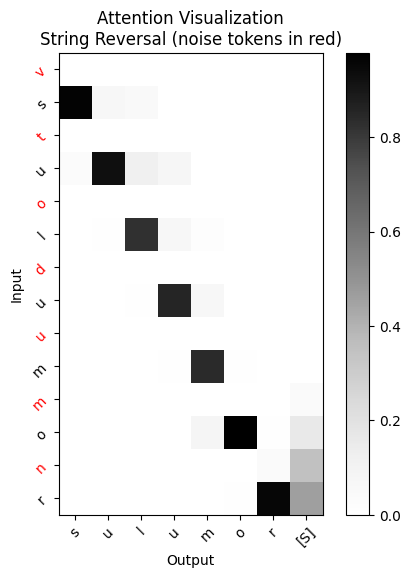

In [ ]:
xtext = X_test[index]
xtext = [index_to_token[i] for i in xtext]
ytext = list(y) + ['[S]']

# Recall that each column is the attention weights for a token in the output
plt.figure(figsize=(6, 6))

plt.imshow(attentions, cmap='Greys')
# Matplot lib reverses the y-axis, so we need to reverse the labels
plt.gca().invert_yaxis()
plt.xticks(range(len(ytext)), ytext, rotation=45)

# Make the non-noise tokens blue in the yticks, and the noise tokens red
plt.yticks(range(len(xtext)), xtext, rotation=45)
for i, label in enumerate(plt.gca().get_yticklabels()):
    if i % 2 == 0:
        label.set_color('black')
    else:
        label.set_color('red')

plt.ylabel('Input')
plt.xlabel('Output')

plt.title('Attention Visualization\nString Reversal (noise tokens in red)')

plt.colorbar()
plt.savefig('attention.png', dpi=300)
# plt.show()